<a href="https://colab.research.google.com/github/kundajelab/locusselect/blob/master/examples/regression%20on%20200%20bp%20genome%20bins.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
#load dragonn tutorial utilities 
%reload_ext autoreload
%autoreload 2
%matplotlib inline
import warnings
warnings.filterwarnings('ignore')
from numpy.random import seed
seed(1234)

In [0]:
!pip install locusselect 

## Regression K562 DNAse model (trained genomewide), fully connected layer embeddings 

In [0]:
## generate embeddings at the -2 layer 
import locusselect 
from locusselect.embeddings import * 
from locusselect.deeplift import * 
from locusselect.utils import * 

In [0]:
#first, we get embeddings from the model fully connected layer 
fc_embedding_args={"input_bed_file":"/srv/scratch/annashch/deeplearning/encode4crispr/k562_dnase/optimal_peak.narrowPeak.gz",
                   "model_hdf5":"/srv/scratch/annashch/deeplearning/encode4crispr/k562_dnase/regression/DNASE.K562.regressionlabels.allbins.0",
                   "ref_fasta":"/mnt/data/annotations/by_release/hg38/GRCh38_no_alt_analysis_set_GCA_000001405.15.fasta",
                   "center_on_summit":True,
                   "flank":500,
                   "embedding_layer":-2,
                   "expand_dims":True,
                   "threads":20}

fc_regions, fc_embeddings = compute_embeddings(fc_embedding_args)
## alternatively, get the pre-generated embeddings 
#fc_regions,fc_embeddings,data_type=load_embedding("k562_dnase_regression_embeddings.0.-2.npz")

got model architecture
loaded model weights
loaded model
obtained embedding layer model
created data generator
210/210 [==============================] - 28s 132ms/step
got embeddings
got region labels


In [0]:
#next, we get deepLIFT scores as embeddings 
deeplift_args={"input_bed_file":"/srv/scratch/annashch/deeplearning/encode4crispr/k562_dnase/optimal_peak.narrowPeak.gz",
                "model_hdf5":"/srv/scratch/annashch/deeplearning/encode4crispr/k562_dnase/regression/DNASE.K562.regressionlabels.allbins.0",
                "ref_fasta":"/mnt/data/annotations/by_release/hg38/GRCh38_no_alt_analysis_set_GCA_000001405.15.fasta",
                "center_on_summit":True,
                "flank":500,
                "embedding_layer":-2,
                "expand_dims":True,
                "threads":20,
                "task_index":0,
                "batch_size":500,
                "deeplift_num_refs_per_seq":1, #PLEASE SET THIS TO AT LEAST 10 IN PRACTISE!!!
                "deeplift_reference":"shuffled_ref",
                "deeplift_layer":-1}
deeplift_regions, deeplift_embeddings=compute_deeplift_scores(deeplift_args)

## alternatively, get the pre-generated embeddings 
deeplift_regions,deeplift_embeddings,data_type=load_embedding("k562_dnase_regression_0.deeplift.npz")

created data generator
420
0
done with batch
1
done with batch
2
done with batch
3
done with batch
4
done with batch
5
done with batch
6
done with batch
7
done with batch
8
done with batch
9
done with batch
10
done with batch
11
done with batch
12
done with batch
13
done with batch
14
done with batch
15
done with batch
16
done with batch
17
done with batch
18
done with batch
19
done with batch
20
done with batch
21
done with batch
22
done with batch
23
done with batch
24
done with batch
25
done with batch
26
done with batch
27
done with batch
28
done with batch
29
done with batch
30
done with batch
31
done with batch
32
done with batch
33
done with batch
34
done with batch
35
done with batch
36
done with batch
37
done with batch
38
done with batch
39
done with batch
40
done with batch
41
done with batch
42
done with batch
43
done with batch
44
done with batch
45
done with batch
46
done with batch
47
done with batch
48
done with batch
49
done with batch
50
done with batch
51
done with b

In [0]:
## alternatively, get the pre-generated embeddings 
deeplift_regions,deeplift_embeddings,data_type=load_embedding("k562_dnase_regression_0.deeplift.npz")

In [0]:
print(fc_regions.shape)
print(deeplift_regions.shape) 
print(fc_embeddings.shape)
print(deeplift_embeddings.shape)

(209865,)
(209865,)
(209865, 1000)
(209865, 1, 1000, 4)


In [0]:
deeplift_regions

array([('chr10', 100006236, 100006689), ('chr10', 100008295, 100008512),
       ('chr10', 100009393, 100010359), ..., ('chrX', 9995809, 9996117),
       ('chrY', 4344721, 4344923), ('chrY', 9141852, 9142034)],
      dtype=object)

In [0]:
from sklearn.decomposition import PCA
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

# Dimension reduction and clustering libraries
import umap
import hdbscan
import sklearn.cluster as cluster
from sklearn.metrics import adjusted_rand_score, adjusted_mutual_info_score

## UMAP clustering on fc layer embeddings 

In [0]:
#we will randomly select 50000 peaks for clustering/visualizing (more than that takes a long time)
n=50000 
indices_for_clustering=np.random.choice(fc_embeddings.shape[0],n) 

In [0]:
standard_embedding = umap.UMAP(random_state=42).fit_transform(fc_embeddings[indices_for_clustering])


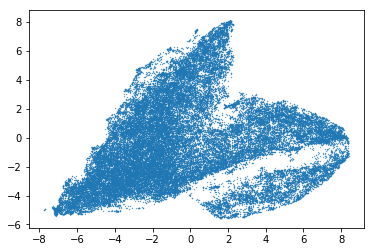

In [0]:
plt.scatter(standard_embedding[:, 0], standard_embedding[:, 1], s=0.1, cmap='Spectral');


In [0]:
clusterable_embedding = umap.UMAP(
    n_neighbors=30,
    min_dist=0.0,
    n_components=2,
    random_state=42,
).fit_transform(fc_embeddings[indices_for_clustering])

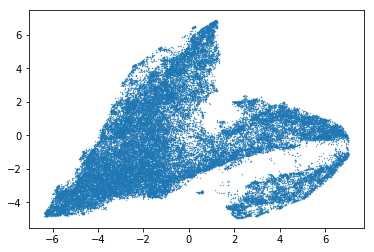

In [0]:
plt.scatter(clusterable_embedding[:, 0], clusterable_embedding[:, 1], s=0.1, cmap='Spectral');

In [0]:
labels = hdbscan.HDBSCAN(
    min_samples=10,
    min_cluster_size=500,
).fit_predict(clusterable_embedding)

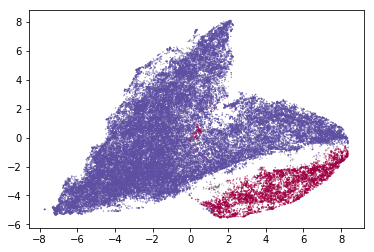

In [0]:
#-1 means the regions were not clustered 
clustered = (labels >= 0)
plt.scatter(standard_embedding[~clustered, 0],
            standard_embedding[~clustered, 1],
            c=(0.5, 0.5, 0.5),
            s=0.1,
            alpha=0.5)
plt.scatter(standard_embedding[clustered, 0],
            standard_embedding[clustered, 1],
            c=labels[clustered],
            s=0.1,
            cmap='Spectral');

In [0]:
clustered_regions=fc_regions[indices_for_clustering]
df=pd.DataFrame({'chrom':[i[0] for i in clustered_regions],
                'start':[i[1] for i in clustered_regions],
                'end':[i[2]for i in clustered_regions],
                'labels':labels})
#write to output bed file for analysis of motif enrichment in clusters 
df.to_csv("regression_fc_layer_embeddings_clusters.bed")

## UMAP clustering on deepLIFT scores

In [0]:
#We condense the deepLIFT scores to 2-D 
deeplift_embeddings=np.squeeze(deeplift_embeddings)
#take the sum over the absolute value of the channel axis 
deeplift_embeddings_collapsed=np.sum(deeplift_embeddings,axis=-1)
deeplift_embeddings_collapsed.shape

(209865, 1000)

In [0]:
#we will randomly select 50000 peaks for clustering/visualizing (more than that takes a long time)
n=50000 
indices_for_clustering=np.random.choice(deeplift_embeddings_collapsed.shape[0],n) 

In [0]:
standard_embedding = umap.UMAP(random_state=42).fit_transform(deeplift_embeddings_collapsed[indices_for_clustering])


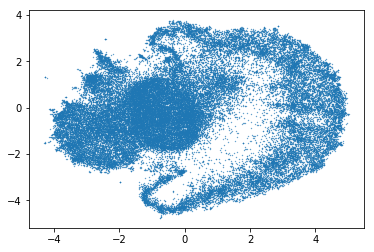

In [0]:
plt.scatter(standard_embedding[:, 0], standard_embedding[:, 1], s=0.1, cmap='Spectral');


In [0]:
clusterable_embedding = umap.UMAP(
    n_neighbors=30,
    min_dist=0.0,
    n_components=2,
    random_state=42,
).fit_transform(deeplift_embeddings_collapsed[indices_for_clustering])

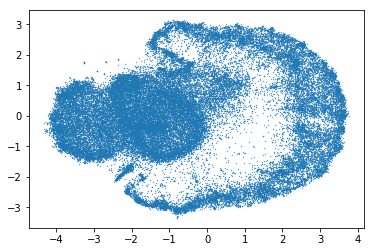

In [0]:
plt.scatter(clusterable_embedding[:, 0], clusterable_embedding[:, 1], s=0.1, cmap='Spectral');

In [0]:
labels = hdbscan.HDBSCAN(
    min_samples=10,
    min_cluster_size=500,
).fit_predict(clusterable_embedding)

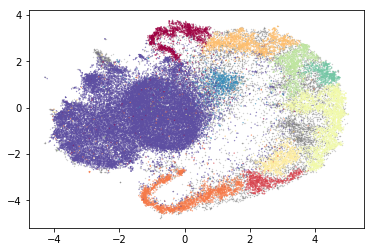

In [0]:
#-1 means the 
clustered = (labels >= 0)
plt.scatter(standard_embedding[~clustered, 0],
            standard_embedding[~clustered, 1],
            c=(0.5, 0.5, 0.5),
            s=0.1,
            alpha=0.5)
plt.scatter(standard_embedding[clustered, 0],
            standard_embedding[clustered, 1],
            c=labels[clustered],
            s=0.1,
            cmap='Spectral');

In [0]:
deeplift_regions.shape

(209865,)

In [0]:
clustered_regions=deeplift_regions[indices_for_clustering]
df=pd.DataFrame({'chrom':[i[0] for i in clustered_regions],
                'start':[i[1] for i in clustered_regions],
                'end':[i[2]for i in clustered_regions],
                'labels':labels})
#write to output bed file for analysis of motif enrichment in clusters 
df.to_csv("regression_deeplift_embeddings_clusters.bed")